# Stochastic Integrator Tests

This notebook demonstrates and tests different stochastic integrators implemented in the `KineticsSandbox`. The following steps are covered:
- Set up a system using the `D1` class in `systems/systems`
- Set up Bolhuis potential using the `Bolhuis` class from `potentials/D1`
- Test basic integration steps (A_step, B_step, O_step)
- Compare different integrators:
  - Euler-Maruyama (EM)
  - ABO (Position-Force-Ornstein)
  - BAOAB (Force-Position-Ornstein-Position-Force)
  - OBABO (Ornstein-Force-Position-Force-Ornstein)
  - Other splitting schemes

In [1]:
#-----------------------------------------
#   I M P O R T S 
#-----------------------------------------
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const

# local packages and modules
from system import system
from potential import D1
from integrator import D1_stochastic


### Instead of Bolhuis, use Harmonic

# For inline plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)


#-----------------------------------------
#   S E T U P
#-----------------------------------------
# Set random seed for reproducibility
np.random.seed(42)

# System parameters
m = 100.0
x = 0.0
v = 0.0 
T = 300.0
xi = 1.0
dt = 0.001
h = 0.001

# Initialize system
sys = system.D1(m, x, v, T, xi, dt, h)

# Initialize Bolhuis potential
param = [2, 2, 5, 1, 2, 0]

quad_x = 0
quad_k = 1
param_quad = [quad_k, quad_x]
pot = D1.Quadratic(param_quad)

print("-----------------------------------------------------------------------")
print(" Initialized system ")
print("-----------------------------------------------------------------------")
print(f"Mass: {sys.m} u")
print(f"Position: {sys.x} nm")
print(f"Velocity: {sys.v} nm/ps")
print(f"Temperature: {sys.T} K")
print(f"Collision frequency: {sys.xi} 1/ps")
print(f"Time step: {sys.dt} ps")

-----------------------------------------------------------------------
 Initialized system 
-----------------------------------------------------------------------
Mass: 100.0 u
Position: 0.0 nm
Velocity: 0.0 nm/ps
Temperature: 300.0 K
Collision frequency: 1.0 1/ps
Time step: 0.001 ps


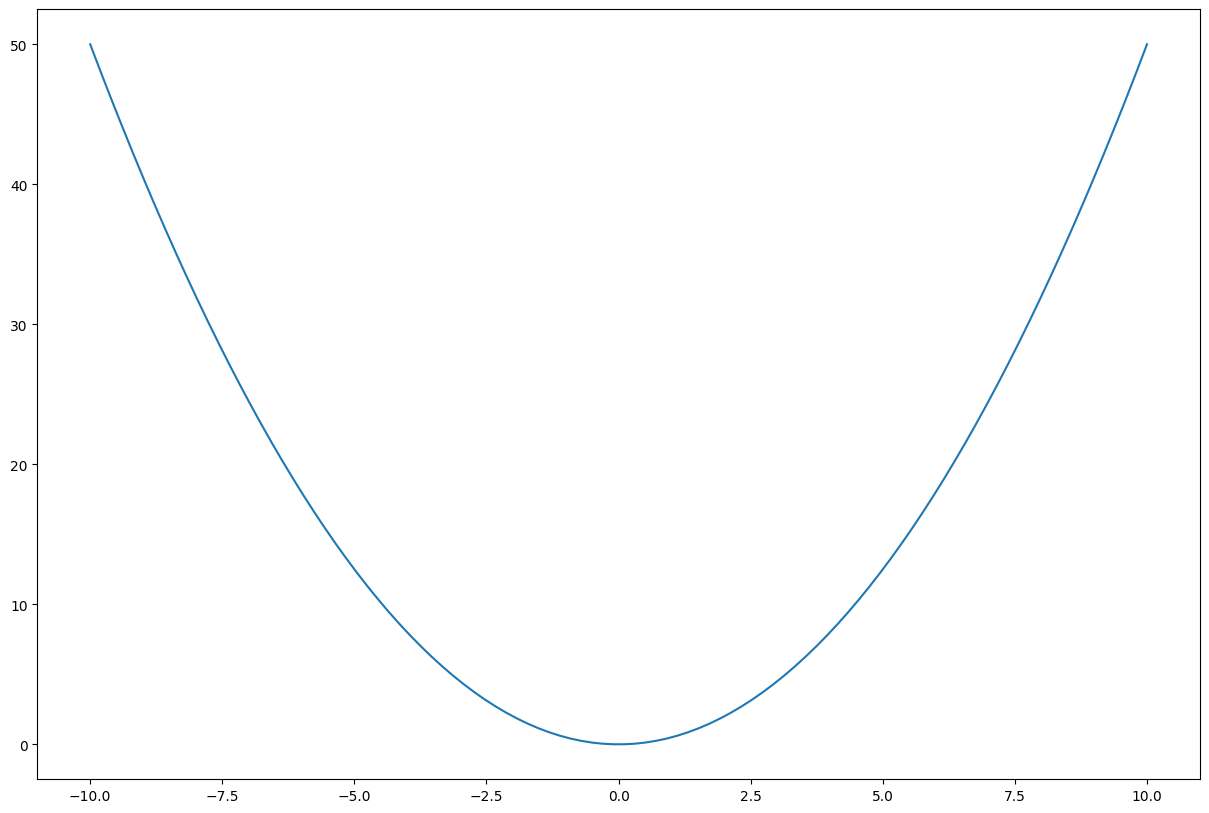

In [ ]:
X_RANGE_1 = 10

### TEST PARAMETERS AND TIME PARAMETERS ETC!!! 

plt.plot(np.linspace(-X_RANGE_1, X_RANGE_1,100), (pot.potential(np.linspace(-X_RANGE_1,X_RANGE_1,100))))


## Basic Steps in Langevin Dynamics

The Langevin dynamics can be split into three basic operations:
1. **A-step**: Position update (kinetic part)
   - x(t + dt) = x(t) + v(t)dt

2. **B-step**: Velocity update from force
   - v(t + dt) = v(t) + F(x)/m * dt

3. **O-step**: Ornstein-Uhlenbeck process
   - Handles friction and random forces
   - Represents the thermostat

Different combinations of these steps lead to various integrators with different properties.

In [3]:
#-----------------------------------------
#   T E S T   B A S I C   S T E P S
#-----------------------------------------
# Create test systems
sys_A = system.D1(m, 1.0, 2.0, T, xi, dt, h)
sys_B = system.D1(m, 1.0, 2.0, T, xi, dt, h)
sys_O = system.D1(m, 1.0, 2.0, T, xi, dt, h)

print("\nTesting basic steps:")

# Test A_step
print("\nA_step:")
print(f"Before - x: {sys_A.x:.6f}, v: {sys_A.v:.6f}")
D1_stochastic.A_step(sys_A)
print(f"After  - x: {sys_A.x:.6f}, v: {sys_A.v:.6f}")

# Test B_step
print("\nB_step:")
print(f"Before - x: {sys_B.x:.6f}, v: {sys_B.v:.6f}")
D1_stochastic.B_step(sys_B, pot)
print(f"After  - x: {sys_B.x:.6f}, v: {sys_B.v:.6f}")

# Test O_step
print("\nO_step:")
print(f"Before - x: {sys_O.x:.6f}, v: {sys_O.v:.6f}")
D1_stochastic.O_step(sys_O)
print(f"After  - x: {sys_O.x:.6f}, v: {sys_O.v:.6f}")


Testing basic steps:

A_step:
Before - x: 1.000000, v: 2.000000
After  - x: 1.002000, v: 2.000000

B_step:
Before - x: 1.000000, v: 2.000000
After  - x: 1.000000, v: 1.999990

O_step:
Before - x: 1.000000, v: 2.000000
After  - x: 1.000000, v: 2.001508


In [4]:
#-----------------------------------------
#   G E N E R A T E   T R A J E C T O R I E S
#-----------------------------------------
def generate_trajectory(integrator_func, n_steps=10000):
    """Generate trajectory using specified integrator"""
    sys_local = system.D1(m, x, v, T, xi, dt, h)
    x_traj = np.zeros(n_steps)
    v_traj = np.zeros(n_steps)
    
    for i in range(n_steps):
        integrator_func(sys_local, pot)
        x_traj[i] = sys_local.x
        v_traj[i] = sys_local.v
    
    return x_traj, v_traj

# Generate trajectories for all integrators
n_steps = 10000
time = np.arange(n_steps) * dt

integrators = {
    'EM': D1_stochastic.EM,
    'ABO': D1_stochastic.ABO,
    'BAOAB': D1_stochastic.BAOAB,
    'BOAOB': D1_stochastic.BOAOB,
    'OBABO': D1_stochastic.OBABO,
    'OABAO': D1_stochastic.OABAO,
    'BAOA': D1_stochastic.BAOA
}

trajectories = {}
for name, integrator in integrators.items():
    print(f"Generating trajectory for {name}...")
    trajectories[name] = generate_trajectory(integrator)

Generating trajectory for EM...
Generating trajectory for ABO...
Generating trajectory for BAOAB...
Generating trajectory for BOAOB...
Generating trajectory for OBABO...
Generating trajectory for OABAO...
Generating trajectory for BAOA...


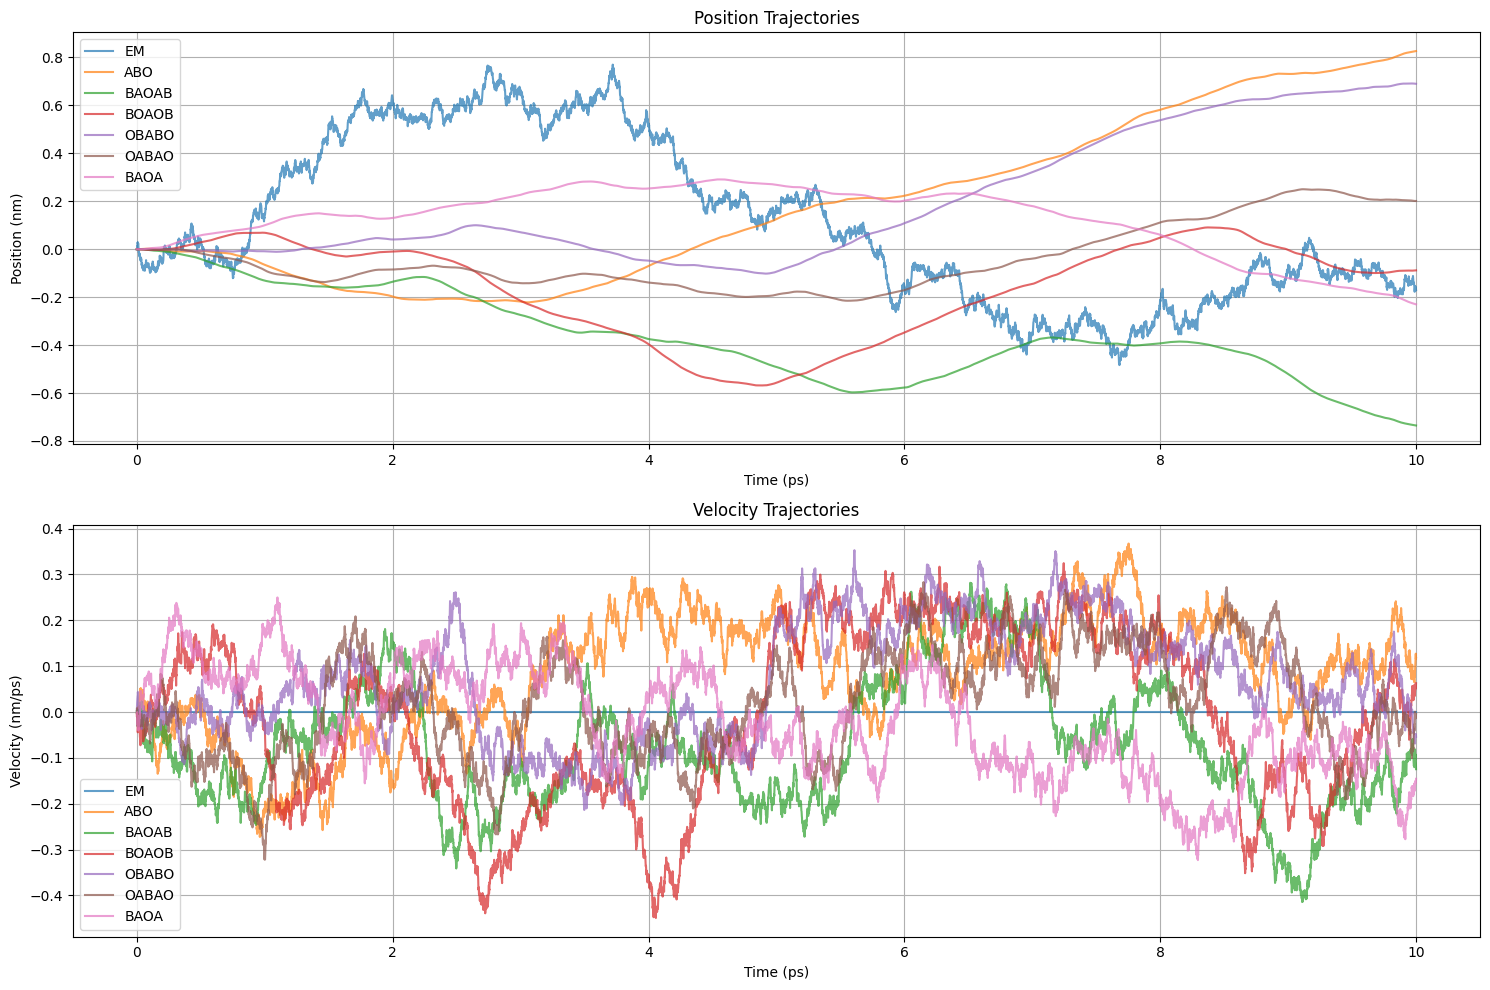

In [5]:
#-----------------------------------------
#   P L O T   T R A J E C T O R I E S
#-----------------------------------------
plt.figure(figsize=(15, 10))

# Position trajectories
plt.subplot(2, 1, 1)
for name, (x_traj, _) in trajectories.items():
    plt.plot(time, x_traj, label=name, alpha=0.7)
plt.xlabel('Time (ps)')
plt.ylabel('Position (nm)')
plt.title('Position Trajectories')
plt.legend()
plt.grid(True)

# Velocity trajectories
plt.subplot(2, 1, 2)
for name, (_, v_traj) in trajectories.items():
    plt.plot(time, v_traj, label=name, alpha=0.7)
plt.xlabel('Time (ps)')
plt.ylabel('Velocity (nm/ps)')
plt.title('Velocity Trajectories')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

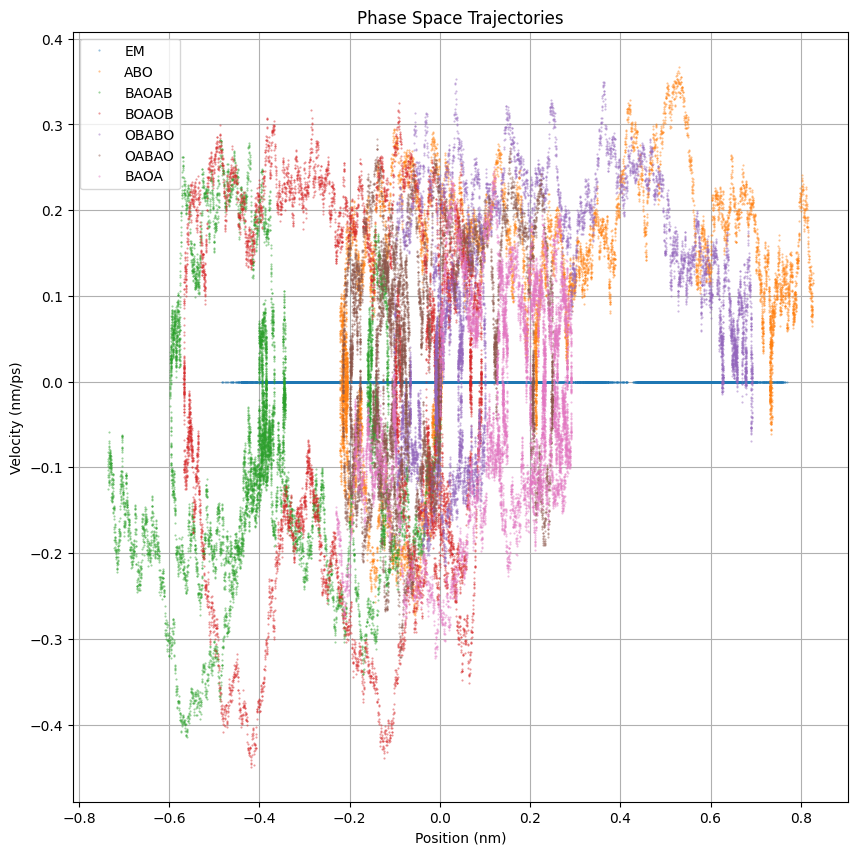

In [6]:
#-----------------------------------------
#   P H A S E   S P A C E   P L O T
#-----------------------------------------
plt.figure(figsize=(10, 10))
for name, (x_traj, v_traj) in trajectories.items():
    plt.plot(x_traj, v_traj, '.', label=name, alpha=0.5, markersize=1)
plt.xlabel('Position (nm)')
plt.ylabel('Velocity (nm/ps)')
plt.title('Phase Space Trajectories')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#-----------------------------------------
#   A N A L Y S I S
#-----------------------------------------
print("\nTrajectory Statistics:")
for name, (x_traj, v_traj) in trajectories.items():
    print(f"\n{name}:")
    print(f"  Position - Mean: {np.mean(x_traj):.6f}, Std: {np.std(x_traj):.6f}")
    print(f"  Velocity - Mean: {np.mean(v_traj):.6f}, Std: {np.std(v_traj):.6f}")
    
    # Calculate energy conservation
    KE = 0.5 * m * v_traj**2
    PE = np.array([pot.potential(x) for x in x_traj])  # Changed from V to potential
    E_total = KE + PE
    
    print(f"  Energy - Mean: {np.mean(E_total):.6f}, Std: {np.std(E_total):.6f}")
    print(f"  Energy drift: {(E_total[-1] - E_total[0])/E_total[0]:.6f}")


Trajectory Statistics:

EM:
  Position - Mean: 0.111441, Std: 0.338158
  Velocity - Mean: 0.000000, Std: 0.000000
  Energy - Mean: 0.063385, Std: 0.071338
  Energy drift: 30413.846492

ABO:
  Position - Mean: 0.187449, Std: 0.335805
  Velocity - Mean: 0.082653, Std: 0.128629
  Energy - Mean: 1.242796, Std: 1.164317
  Energy drift: 4459.074021

BAOAB:
  Position - Mean: -0.364534, Std: 0.184298
  Velocity - Mean: -0.073562, Std: 0.139560
  Energy - Mean: 1.327847, Std: 1.419941
  Energy drift: 5238.292518

BOAOB:
  Position - Mean: -0.161565, Std: 0.201584
  Velocity - Mean: -0.008789, Std: 0.186407
  Energy - Mean: 1.774605, Std: 1.736007
  Energy drift: 58.788240

OBABO:
  Position - Mean: 0.195143, Std: 0.263008
  Velocity - Mean: 0.068996, Std: 0.122464
  Energy - Mean: 1.041521, Std: 1.140278
  Energy drift: 389.378619

OABAO:
  Position - Mean: -0.040096, Std: 0.135742
  Velocity - Mean: 0.020070, Std: 0.117326
  Energy - Mean: 0.718425, Std: 0.758497
  Energy drift: 111.050722



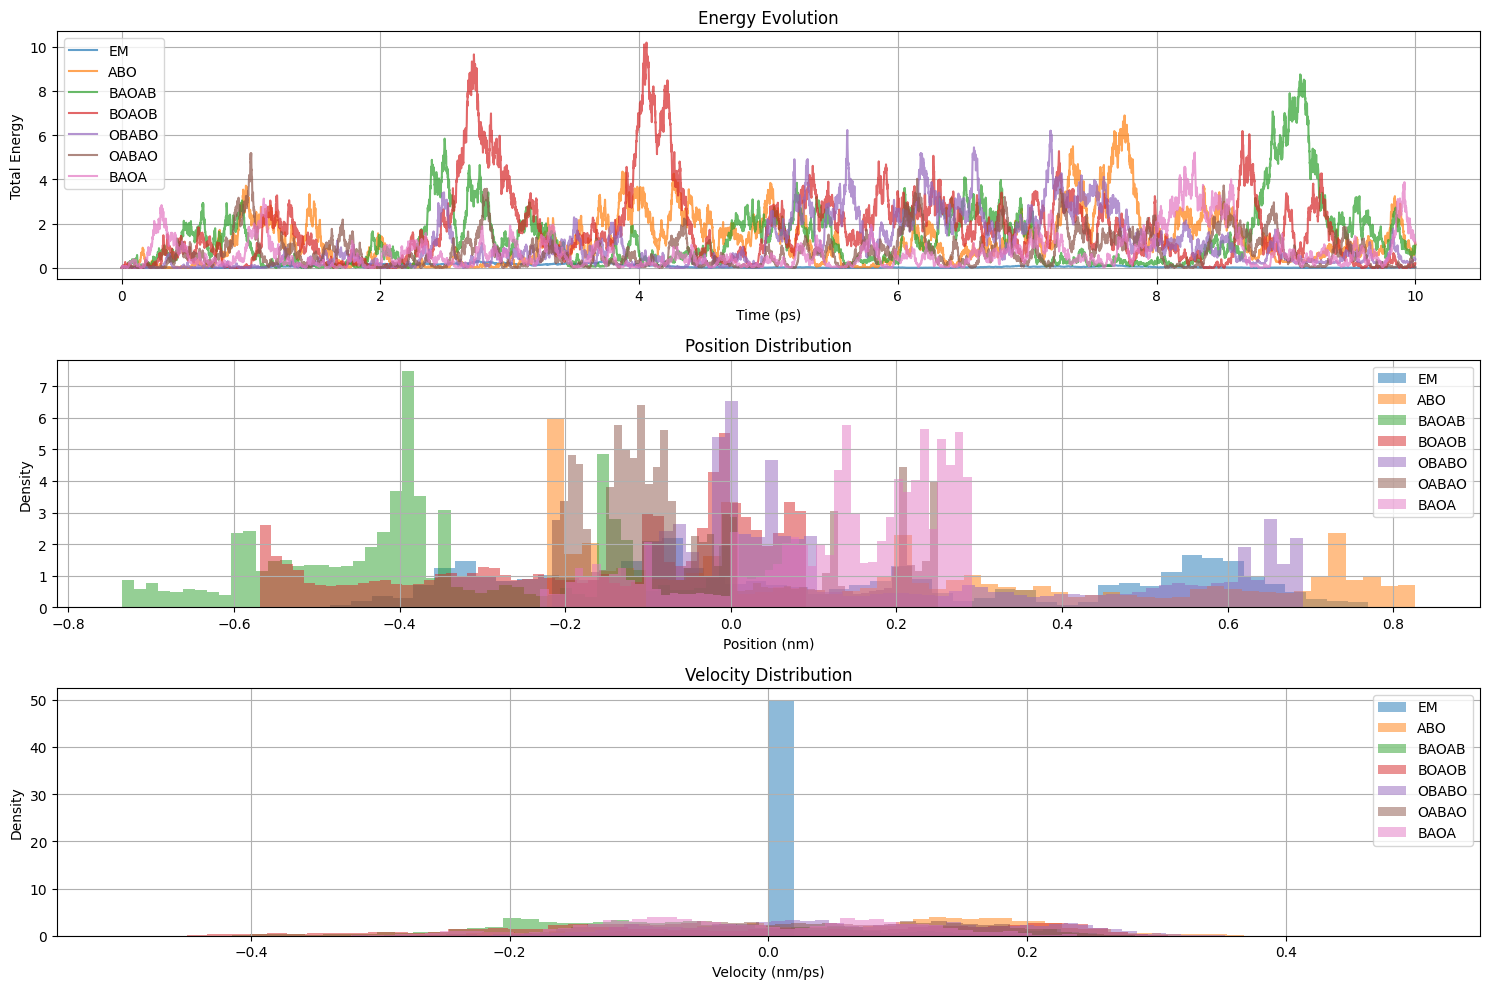

In [8]:
#-----------------------------------------
#   A N A L Y S I S   P L O T S
#-----------------------------------------
# Plot energy evolution
plt.figure(figsize=(15, 10))

# Total Energy plot
plt.subplot(3, 1, 1)
for name, (x_traj, v_traj) in trajectories.items():
    KE = 0.5 * m * v_traj**2
    PE = np.array([pot.potential(x) for x in x_traj])
    E_total = KE + PE
    plt.plot(time, E_total, label=f'{name}', alpha=0.7)
plt.xlabel('Time (ps)')
plt.ylabel('Total Energy')
plt.title('Energy Evolution')
plt.legend()
plt.grid(True)

# Position distribution
plt.subplot(3, 1, 2)
for name, (x_traj, _) in trajectories.items():
    plt.hist(x_traj, bins=50, density=True, alpha=0.5, label=name)
plt.xlabel('Position (nm)')
plt.ylabel('Density')
plt.title('Position Distribution')
plt.legend()
plt.grid(True)

# Velocity distribution
plt.subplot(3, 1, 3)
for name, (_, v_traj) in trajectories.items():
    plt.hist(v_traj, bins=50, density=True, alpha=0.5, label=name)
plt.xlabel('Velocity (nm/ps)')
plt.ylabel('Density')
plt.title('Velocity Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()